In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import corner
from scipy import integrate 
from matplotlib import rc
rc('text', usetex=True)
plt.rcParams.update({'font.size': 12})
from multiprocessing import Pool, cpu_count
import emcee
from IPython.display import display, Math
from tqdm import tqdm

pip install nameofpackage

Lets us first import the data and define the proper things

In [4]:
data=np.loadtxt("OHD.txt")
z_data=data[:,0]
H_data=data[:,1]
H_err= data[:,2]
errsq=1/H_err**2
print(z_data)
print(H_data)
len(z_data)

[0.0708 0.09   0.12   0.17   0.179  0.199  0.2    0.24   0.27   0.28
 0.35   0.352  0.38   0.3802 0.4    0.4004 0.4247 0.43   0.44   0.4497
 0.47   0.4783 0.48   0.51   0.57   0.593  0.6    0.61   0.68   0.73
 0.781  0.875  0.88   0.9    1.037  1.3    1.363  1.43   1.53   1.75
 1.965  2.34   2.36  ]
[ 69.    69.    68.6   83.    75.    75.    72.9   79.69  77.    88.8
  84.4   83.    81.2   83.    95.    77.    87.1   86.45  82.6   92.8
  89.    80.9   97.    90.9   92.4  104.    87.9   98.96  92.    97.3
 105.   125.    90.   117.   154.   168.   160.   177.   140.   202.
 186.5  222.   226.  ]


43

Let us define the model

In [7]:
def Hmodel(z, params):
    om0, H0 = params
    Hval=H0*np.sqrt(om0*(1+z)**3 + (1-om0))
    return Hval

Here we will define the model parameters and returning the chisquared $\newline$
 $\chi^2 = [D-T]^T \frac{1}{\sigma^2} [D-T]$, where $\sigma^2$ also shows the particular diagonal of covariance matrix $Cov^{-1}$ error on that value. Here $D$ shows the data and $T$ shows the theoretical model data.

In [8]:
def chisq(D,T,err):
    diff= D-T
    '''diffT=diff.T
    chisq=diffT.dot(errsq.dot(diff))'''
    chisq=np.sum(((D-T)/err)**2)
    return chisq


Here the model parameters and corresponding chisquare will be calculated.

In [9]:
def modelparameter(params):
    om0, H0 = params
    HT = np.zeros(len(z_data))
    if not (30 < H0 < 100 and 0 < om0 <0.5):
        return -np.inf
      
    for i in range(len(z_data)):
        HT[i] = Hmodel(z_data[i], params)
    Hubblechi = chisq(H_data, HT, H_err)
    return Hubblechi
        
def H_loglike(params):
    H_log = -0.5 * modelparameter(params)
    # Ensure that log likelihood is finite
    if not np.isfinite(H_log):
        return -np.inf
    return H_log



Now we shall do the MCMC coding.

In [11]:
nwalker=200
ndim=2 #this dfines the number of model parameters that required to be constrained.

#let us define the initial position of workers of mcmc
p0 = np.random.uniform(low=[0.00001, 30.], high=[0.5, 99], size=(nwalker, ndim))
sampler=emcee.EnsembleSampler(nwalker,ndim,H_loglike)
sampler.run_mcmc(p0,1000,progress=True)

samples=sampler.get_chain(discard=10,thin=2,flat=True)


100%|██████████| 1000/1000 [00:28<00:00, 35.39it/s]


Parallelization

In [6]:
niter=5000
nwalker=100
ndim=2 #this dfines the number of model parameters that required to be constrained.

#let us define the initial position of workers of mcmc
p0 = np.random.uniform(low=[0.00001, 30.], high=[0.5, 99], size=(nwalker, ndim))
ncpu = cpu_count()
print("{0} CPUs".format(ncpu))
with Pool(processes=7) as pool:
    sampler = emcee.EnsembleSampler(nwalker, ndim,H_loglike, pool=pool)
    sampler.run_mcmc(p0,niter,progress=True)
    

samples=sampler.get_chain(discard=10,thin=2,flat=True)

12 CPUs


In [11]:
samples = sampler.chain.reshape((-1, ndim))
om_mc, H0_mc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
#Both these gives the same result. In below it is in tex format.
print(om_mc, H0_mc)

flat_samples=sampler.get_chain(flat=True)

label=[r'\Omega_M', r'H_0']

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = r"\mathrm{{{3}}} = {0:.2f}_{{-{1:.2f}}}^{{{2:.2f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], label[i])
    display(Math(txt))

(0.25756945401968534, 0.021361449260326903, 0.019941763868532775) (70.59727596877907, 1.4276939084279832, 1.4471432644493518)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Plotting the figures

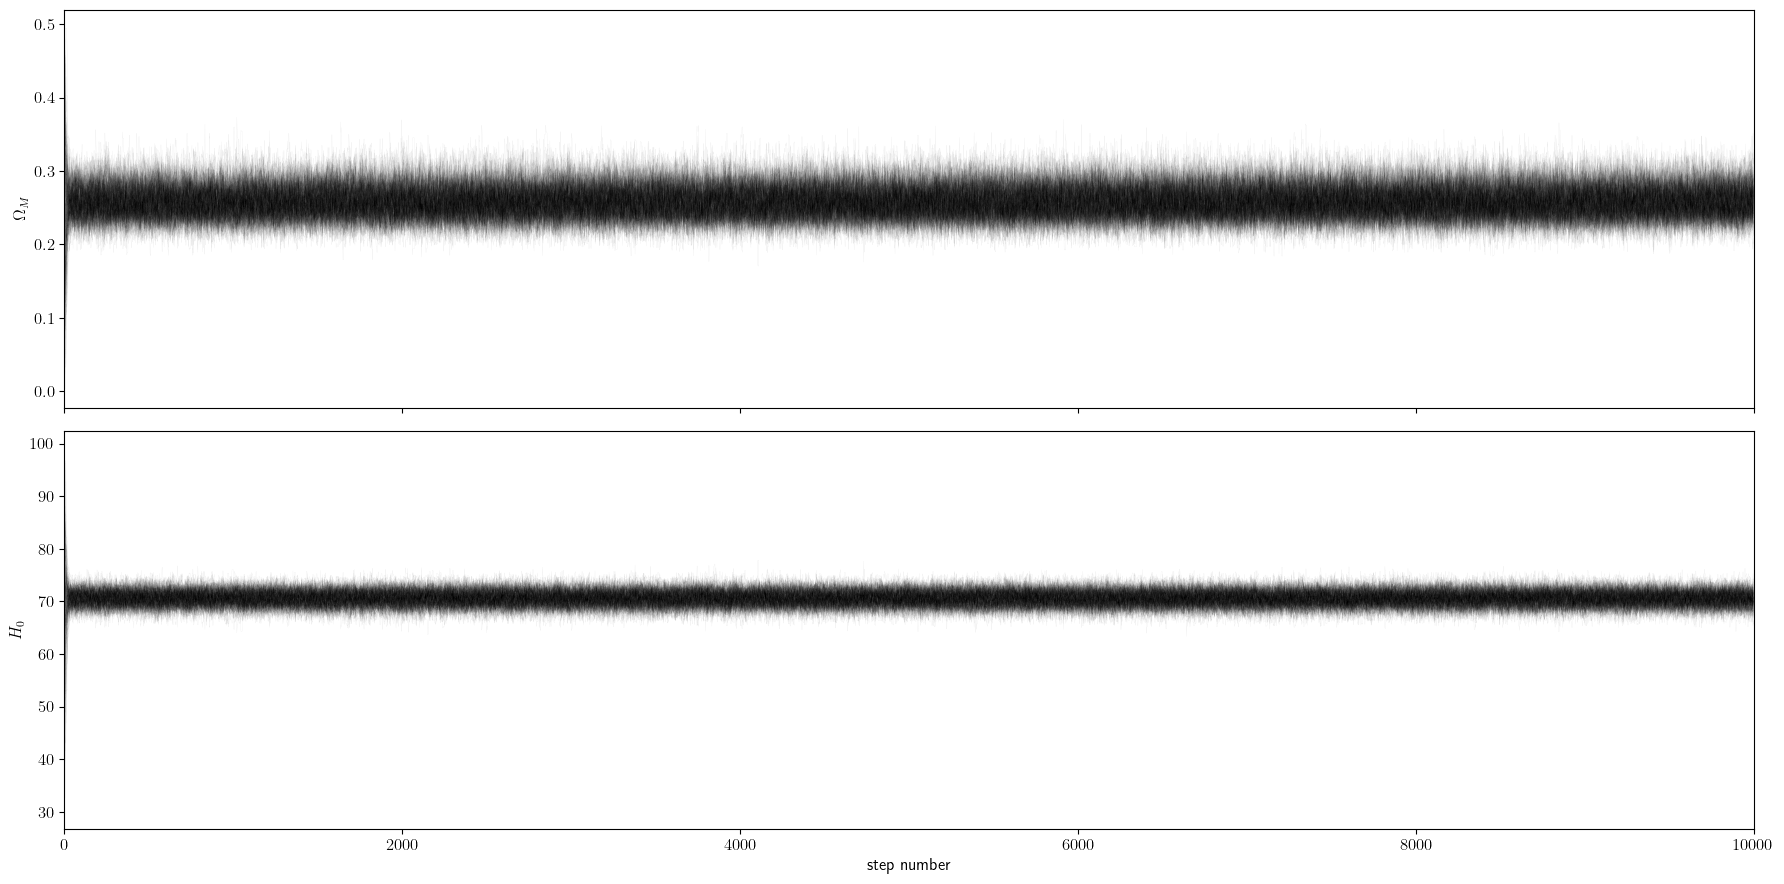

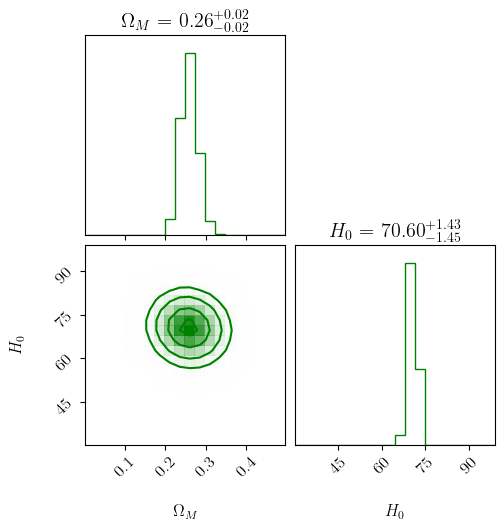

In [12]:
params = [r'$\Omega_M$', r'$H_0$']

#Plotting the traces
thin, discard = 2, 10
fig, axes = plt.subplots(ndim, figsize=(18,9), sharex=True)

#plt.figure(figsize=(18,9))

for i in range(ndim):
    ax = axes[i]
    #plt.subplot(2,ndim//2,i+1) #this is for making two rows.
    ax.plot(sampler.get_chain()[thin:,discard:,i], color='black',alpha=0.1, lw=0.15)
    ax.set_xlim(0, len(sampler.get_chain()))
    ax.set_ylabel(params[i])

axes[-1].set_xlabel("step number");
plt.tight_layout ()

fig=corner.corner(samples,labels=params,show_titles=True,color='green',Truths=[om_mc,H0_mc],smooth=2.,Levels=[0.68,0.95],plot_density=True,plot_datapoints=False)

fig.savefig("corner_plot.pdf")

In [13]:
print(samples.shape)

(2000000, 2)
